# Load the WDC CO2 data for a test

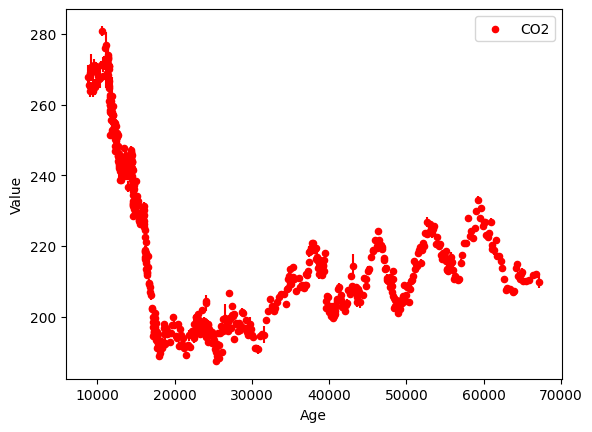

In [11]:
import pandas as pd


df_wdc_co2 = pd.read_excel('data_for_plots.xlsx', sheet_name='WDC CO2', skiprows=1)
# remove nan values for all three dataframes
df_wdc_co2 = df_wdc_co2.dropna()

# rename columns to Age,Value
df_wdc_co2.columns = ['Age', 'Value', 'Error']

# plot the co2 data 
ax = df_wdc_co2.plot(x='Age', y='Value', yerr='Error', kind='scatter', color='red', label='CO2')

In [7]:
df_wdc_co2.info

<bound method DataFrame.info of           Age   Value  Error
0     8806.73  267.90   3.37
1     8900.03  265.45   1.43
2     8995.02  268.86   1.42
3     9091.10  263.95   1.85
4     9188.26  270.60   3.85
..        ...     ...    ...
656  65530.00  210.15   0.48
657  65911.80  210.32   0.53
658  66332.96  211.87   0.86
659  66729.17  212.07   0.80
660  67187.42  209.87   1.74

[661 rows x 3 columns]>

# Gaussian Process Regression (GPR), does not consider CO2 measurement uncertainty

In [24]:

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

X_train = df_wdc_co2['Age'].values.reshape(-1, 1)
y_train = df_wdc_co2['Value'].values

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Define the kernel for the Gaussian Process
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Define and fit the Gaussian Process model with scaled data
gp_scaled = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_scaled.fit(X_train_scaled, y_train_scaled)

X_ = np.linspace(min(df_wdc_co2['Age']), max(df_wdc_co2['Age']), 1000).reshape(-1, 1)
# Make predictions on scaled data
X_scaled = scaler_X.transform(X_)
y_mean_scaled, y_std_scaled = gp_scaled.predict(X_scaled, return_std=True)

# Inverse transform the predictions to original scale
y_mean = scaler_y.inverse_transform(y_mean_scaled.reshape(-1, 1)).ravel()
ci = 1.96 * y_std_scaled * scaler_y.scale_  # Adjusting confidence interval to original scale



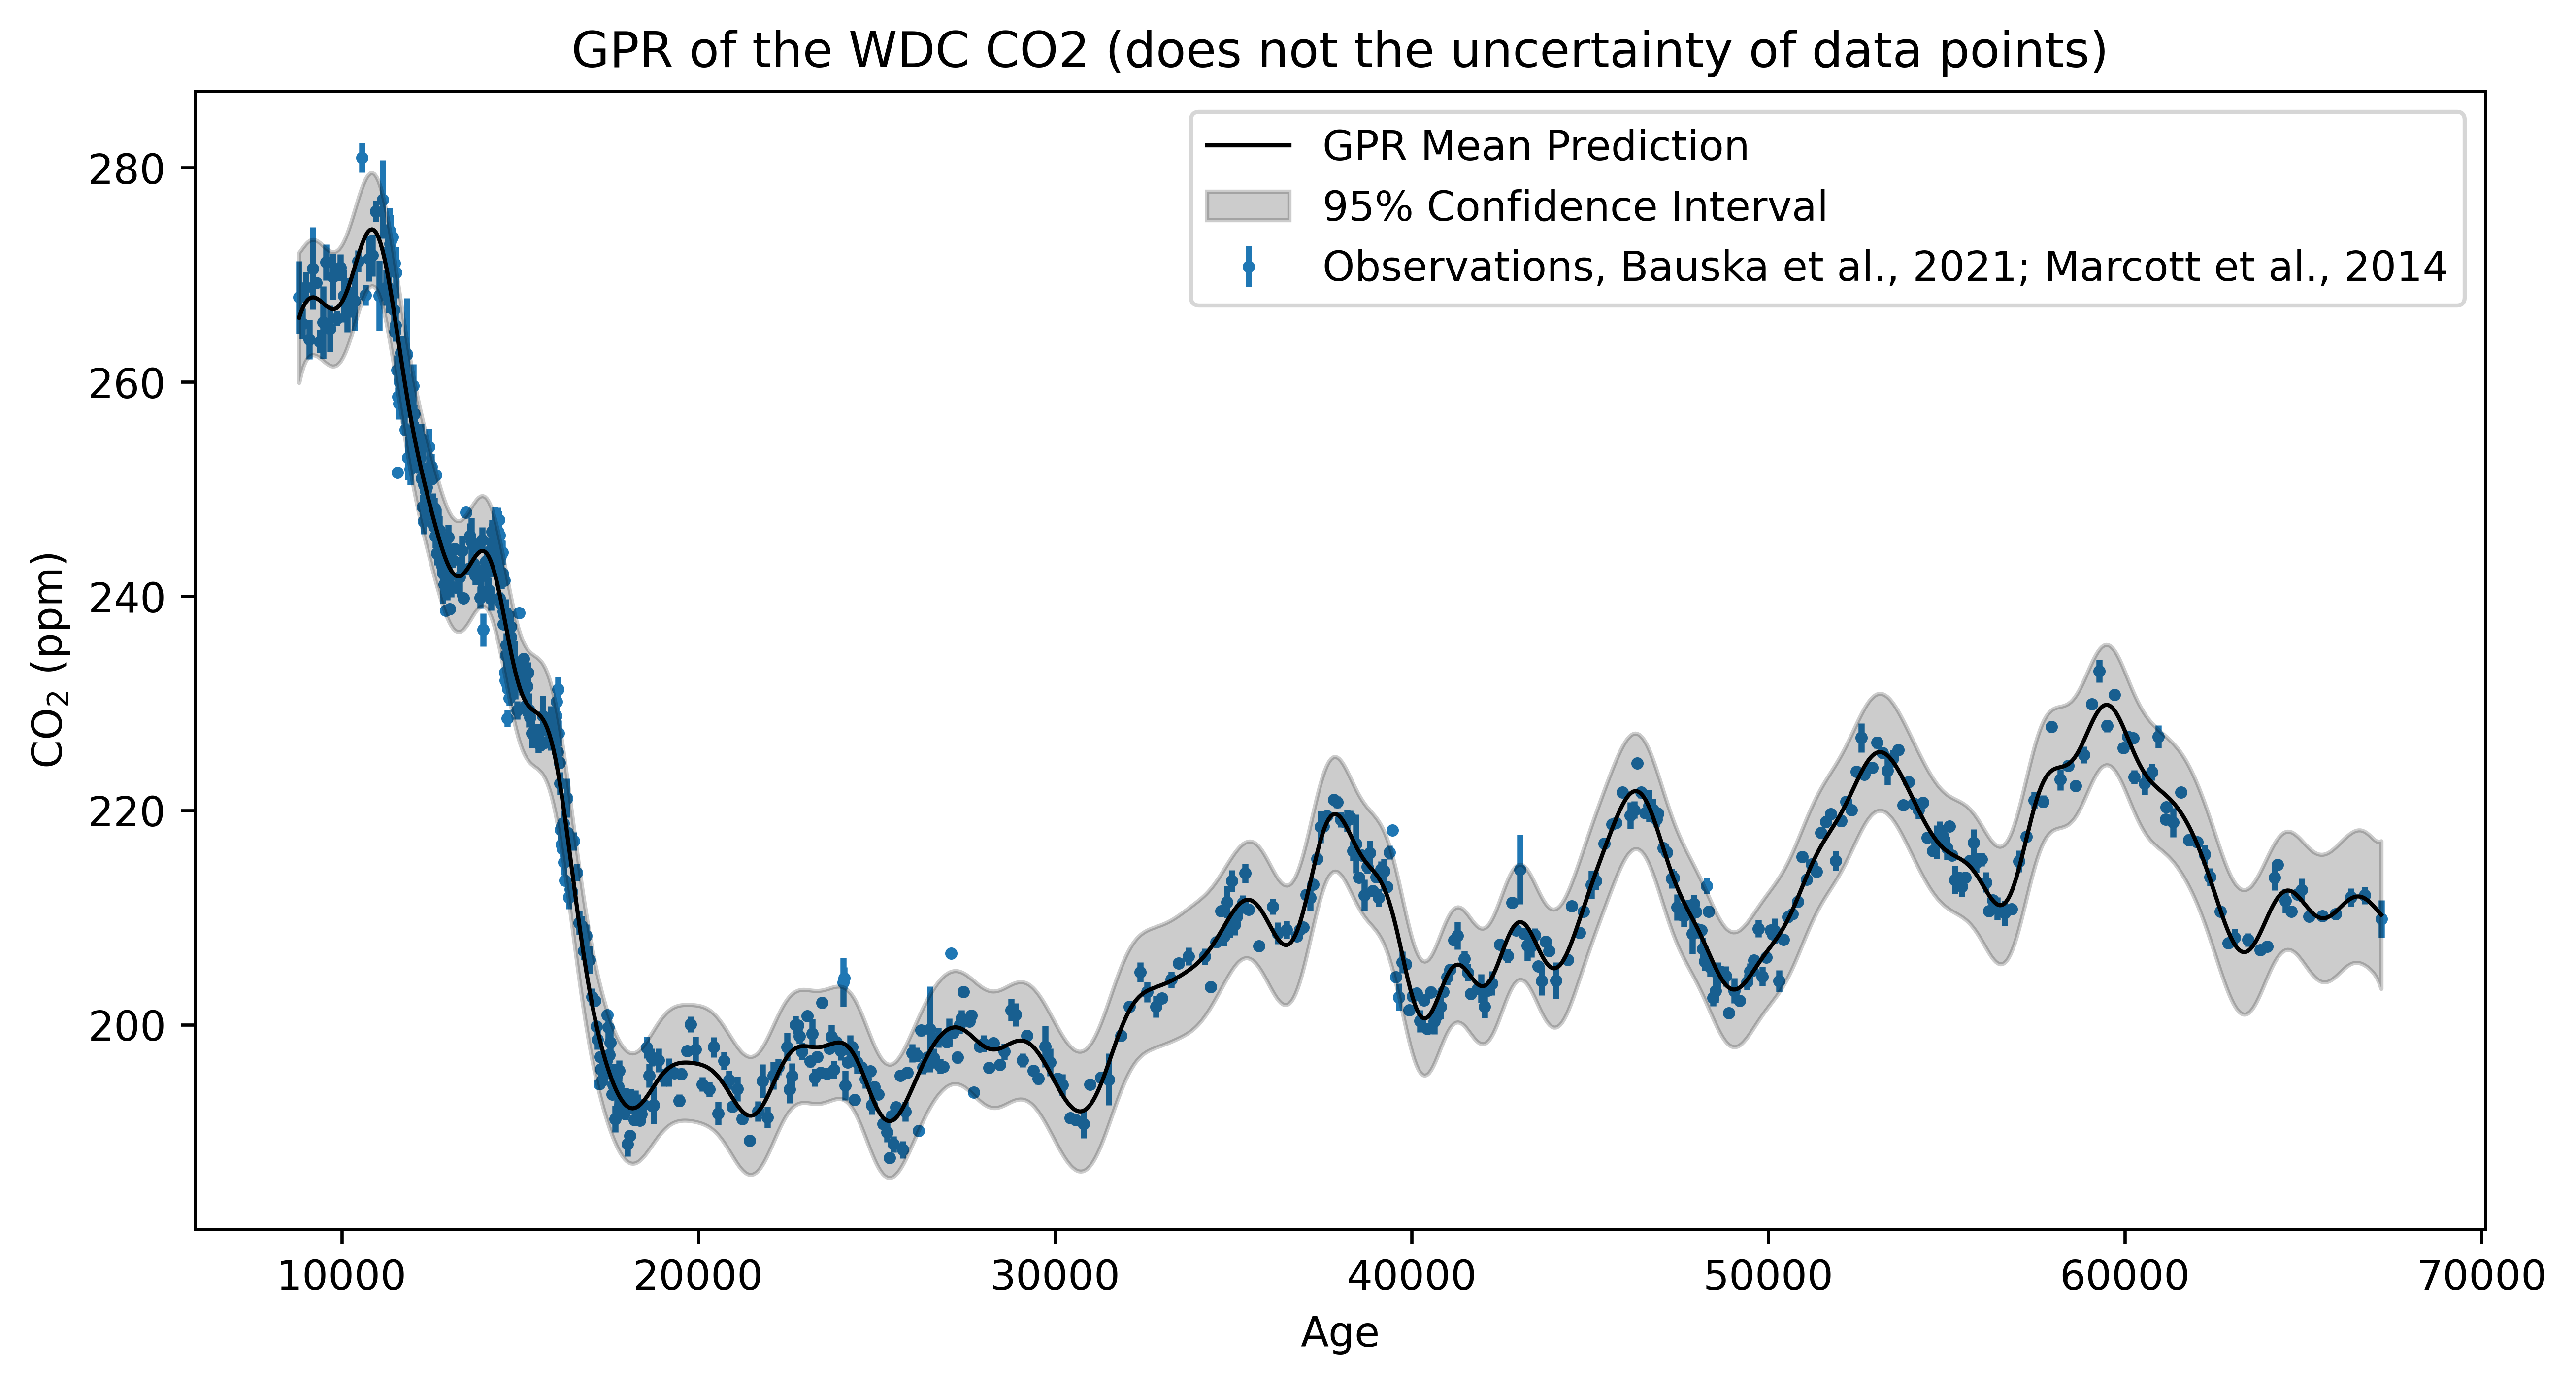

In [29]:
# Plotting
plt.figure(figsize=(10, 5),dpi=600)

plt.errorbar(X_train, y_train, yerr=df_wdc_co2['Error'], fmt='o', label='Observations, Bauska et al., 2021; Marcott et al., 2014',markersize=2,zorder=0)
plt.plot(X_, y_mean, 'k', lw=1, label='GPR Mean Prediction')
plt.fill_between(X_.ravel(), y_mean - ci, y_mean + ci, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('Age')
plt.ylabel('CO$_2$ (ppm)')
plt.title('GPR of the WDC CO2 (does not the uncertainty of data points)')
plt.legend()
plt.show()

# Gaussian Process Regression (GPR), consider the CO2 measurement uncertainty

In [30]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

X_train = df_wdc_co2['Age'].values.reshape(-1, 1)
y_train = df_wdc_co2['Value'].values
y_error = df_wdc_co2['Error'].values  # Errors in y_train

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Define the kernel for the Gaussian Process
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Define and fit the Gaussian Process model with scaled data
# Scale the errors and use them as the alpha parameter
y_error_scaled = scaler_y.scale_ * y_error  # Adjust the errors to the scale of y_train_scaled
gp_scaled = GaussianProcessRegressor(kernel=kernel, alpha=y_error_scaled**2, n_restarts_optimizer=10)
gp_scaled.fit(X_train_scaled, y_train_scaled)

X_ = np.linspace(min(df_wdc_co2['Age']), max(df_wdc_co2['Age']), 1000).reshape(-1, 1)
# Make predictions on scaled data
X_scaled = scaler_X.transform(X_)
y_mean_scaled, y_std_scaled = gp_scaled.predict(X_scaled, return_std=True)

# Inverse transform the predictions to original scale
y_mean = scaler_y.inverse_transform(y_mean_scaled.reshape(-1, 1)).ravel()
ci = 1.96 * y_std_scaled * scaler_y.scale_  # Adjusting confidence interval to original scale


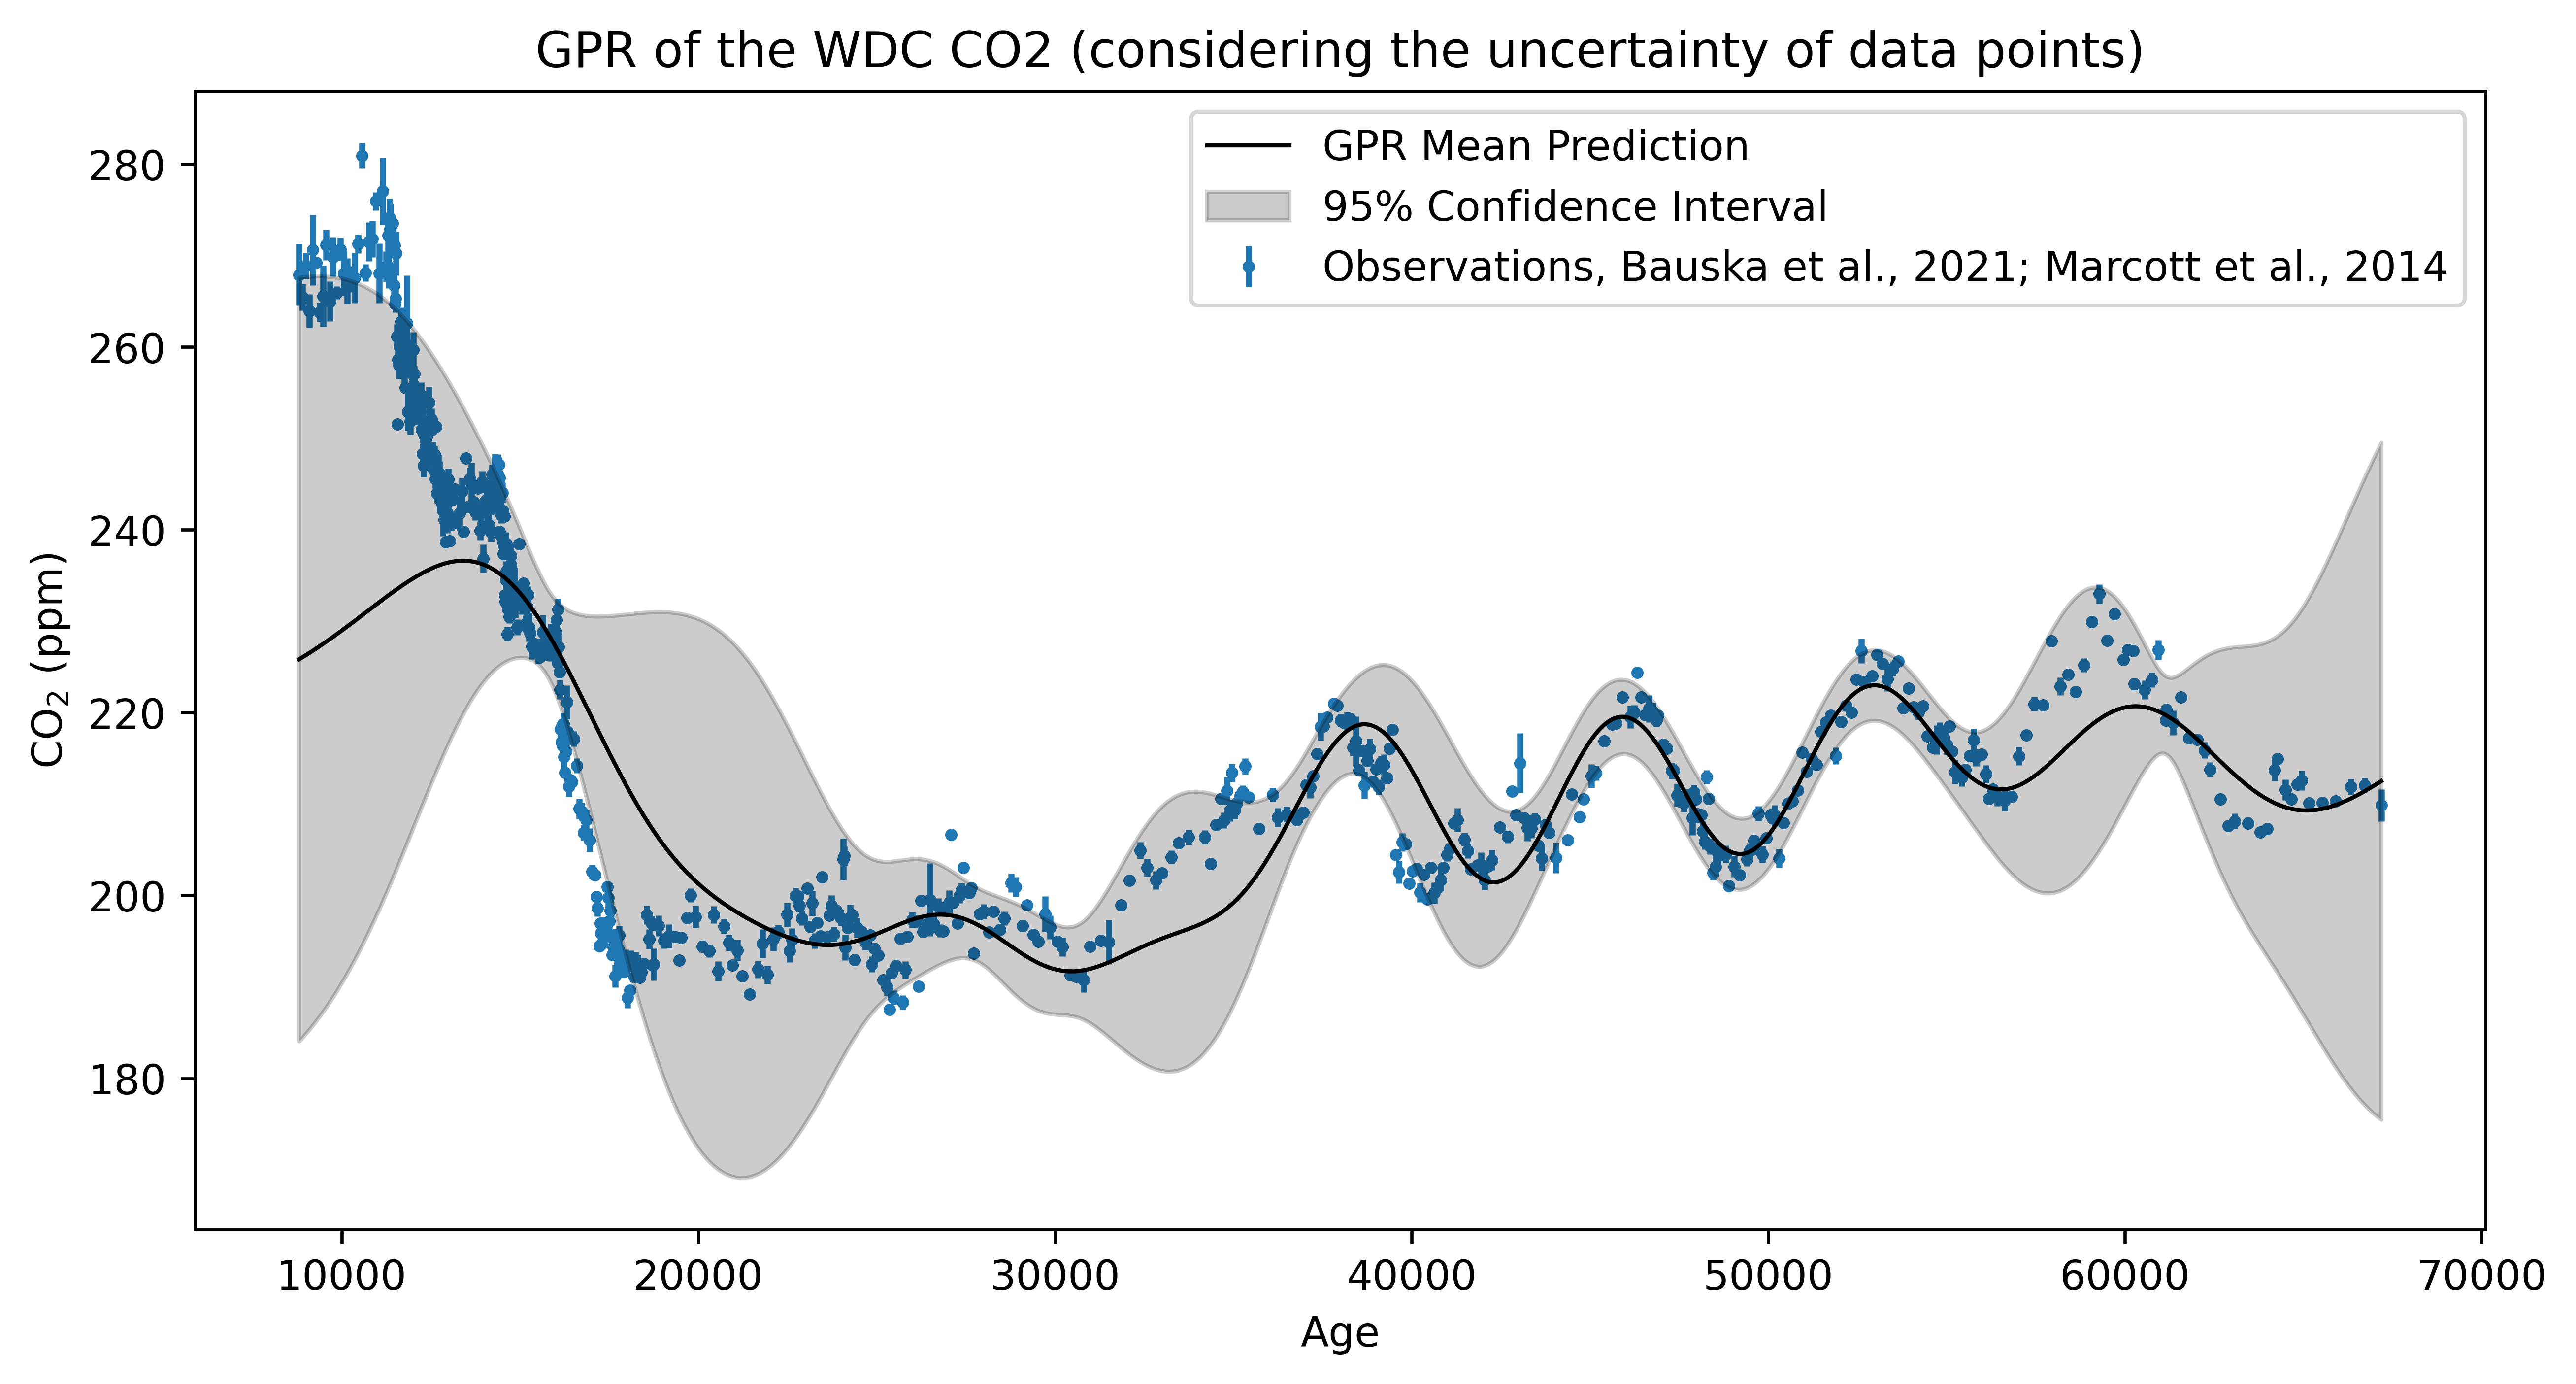

In [31]:
# Plotting
plt.figure(figsize=(10, 5),dpi=600)

plt.errorbar(X_train, y_train, yerr=df_wdc_co2['Error'], fmt='o', label='Observations, Bauska et al., 2021; Marcott et al., 2014',markersize=2,zorder=0)
plt.plot(X_, y_mean, 'k', lw=1, label='GPR Mean Prediction')
plt.fill_between(X_.ravel(), y_mean - ci, y_mean + ci, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('Age')
plt.ylabel('CO$_2$ (ppm)')
plt.title('GPR of the WDC CO2 (considering the uncertainty of data points)')
plt.legend()
plt.show()